![](logo_scanpy.svg){width=50% fig-align="center"}

클러스터링으로 scRNA-seq 데이터를 여러 그룹으로 나눈 뒤에는 해당 그룹이 어떤 세포인지 아는 것은 분석 결과를 해석할 때 중요합니다. 세포 유형을 예측하는 방법에는 크게 두 가지 방법이 있습니다. 레퍼런스 scRNA-seq 데이터를 사용해 유사도를 비교하는 방법과 알려진 마커 유전자를 사용해 직접 세포 유형을 지정하는 방법입니다. 레퍼런스 데이터는 이미 세포 유형의 전사체 표현 데이터를 말합니다. 이 데이터를 사용하여 클러스터링된 세포들의 전사체 표현 패턴을 레퍼런스 데이터와 비교하여 가장 유사한 세포 유형을 예측합니다. 여기서는 가장 간단한 `ingest` 방법을 사용해봅니다.

# 들어가며

먼저, 필요한 라이브러리를 로드합니다.

In [1]:
import warnings

import gseapy
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc

# 경고 무시하기
warnings.filterwarnings("ignore")
sc.settings.n_jobs = -1
sc.settings.verbosity = 0  # 오류 (0), 경고 (1), 정보 (2), 힌트 (3)
sc.settings.set_figure_params(
    dpi=60, frameon=False, figsize=(5, 5), facecolor="white", color_map="viridis_r"
)
print(f"사용한 SCANPY 버전: {sc.__version__}")

사용한 SCANPY 버전: 1.10.1


# 세포 유형 예측하기

## 비교 데이터 불러오기

`scanpy.datasets`함수를 사용해 레퍼런스로 사용할 `pbmc3k`데이터를 불러옵니다. 여기서 주의할 점은 레퍼런스 데이터와 실험 데이터는 비슷한 실험 조건을 가져야 한다는 것입니다. 예를 들어, 레퍼런스 데이터가 10X Genomics의 Chromium 플랫폼으로 생성되었다면, 실험 데이터도 동일한 플랫폼으로 생성되어야 합니다. 이는 플랫폼 간의 차이로 인해 발생하는 바이어스를 최소화하기 위함입니다.

In [2]:
adata_ref = sc.datasets.pbmc3k_processed()
adata_ref.obs["sample"] = "pbmc3k"
adata_ref

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'sample'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [3]:
print(adata_ref.shape)
adata_ref.obs.head()

(2638, 1838)


,n_genes,percent_mito,n_counts,louvain,sample
index,,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells,pbmc3k
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,pbmc3k
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells,pbmc3k
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,pbmc3k
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells,pbmc3k


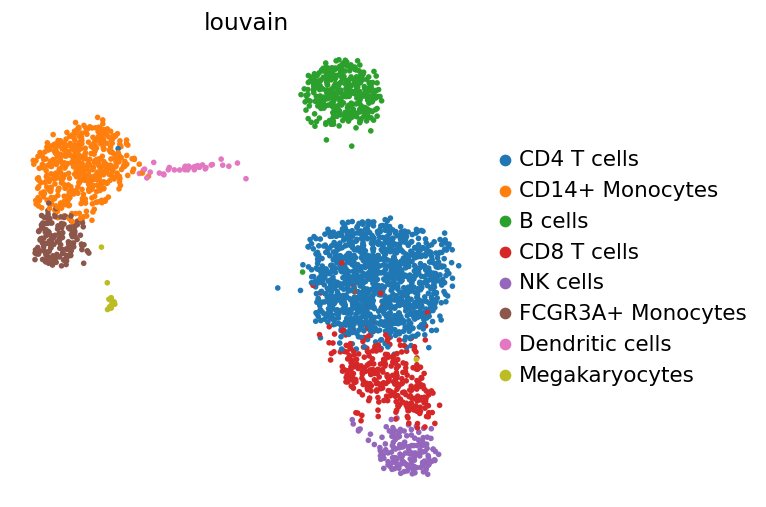

In [4]:
sc.pl.umap(adata_ref, color=["louvain"])

## 분석 데이터 불러오기

클러스터링 단계에서 저장된 코로나19 데이터 개체를 읽어와 보겠습니다.

In [5]:
path_file = "./output/covid/results/scanpy_covid_qc_dr_sc_cl.h5ad"
adata = sc.read_h5ad(path_file)
adata.obs["sample"] = "covid"
adata

AnnData object with n_obs × n_vars = 7227 × 19094
    obs: 'type', 'sample', 'batch', 'n_counts', 'leiden_1.0', 'leiden_0.6', 'leiden_0.4', 'leiden_1.4', 'louvain_1.0', 'louvain_0.6', 'louvain_0.4', 'louvain_1.4', 'kmeans5', 'kmeans10', 'kmeans15', 'hclust_5', 'hclust_10', 'hclust_15'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hclust_10_colors', 'hclust_15_colors', 'hclust_5_colors', 'hvg', 'kmeans10_colors', 'kmeans15_colors', 'kmeans5_colors', 'leiden_0.4', 'leiden_0.4_colors', 'leiden_0.6', 'leiden_0.6_colors', 'leiden_1.0', 'leiden_1.0_colors', 'leiden_1.4', 'leiden_1.4_colors', 'log1p', 'louvain_0.4', 'louvain_0.4_colors', 'louvain_0.6', 'louvain_0.6_colors', 'louvain_1.0', 'louvain_1.0_colors', 'louvain_1.4', 'louvain_1.4_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 't-test', 't-test_ov', 'tsne', 'umap', 'wil

In [6]:
# adata.uns["log1p"]["base"] = None
print(adata.shape)

(7227, 19094)


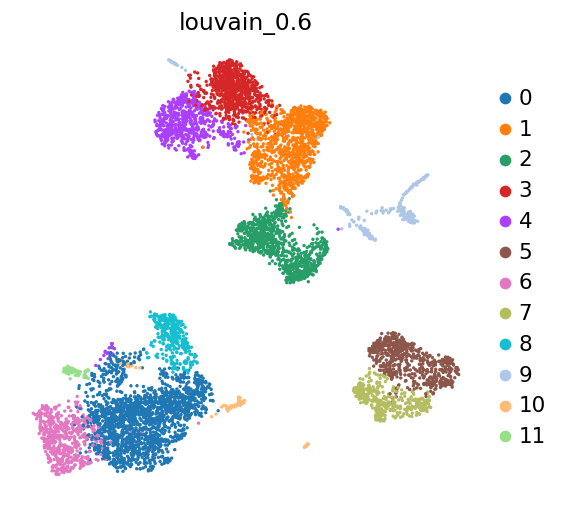

In [7]:
sc.pl.umap(adata, color=["louvain_0.6"])

## Ingest 사용해 예측하기

세포 유형 예측을 위한 또 다른 방법은 Ingest이며, 자세한 내용은 [링크](https://scanpy-tutorials.readthedocs.io/en/latest/integrating-data-using-ingest.html)을 참조하세요. 먼저 두 데이터 집합에 동일한 유전자가 있는지 확인합니다.

In [8]:
var_names = adata_ref.var_names.intersection(adata.var_names)
print(f"타겟 데이터의 유전자 수: {adata.shape[1]}")
print(f"레퍼런스 데이터의 유전자 수: {adata_ref.shape[1]}")
print(f"타겟과 레퍼런스 데이터에서 중첩되는 유전자 수: {len(var_names)}")

타겟 데이터의 유전자 수: 19094
레퍼런스 데이터의 유전자 수: 1838
타겟과 레퍼런스 데이터에서 중첩되는 유전자 수: 1674


먼저 두 데이터 세트에 대해 동일한 유전자 세트를 사용하여 `pca`와 `umap`을 다시 실행해야 합니다.
데이터 세트에 대해 동일한 유전자 세트로 다시 실행해야 합니다.

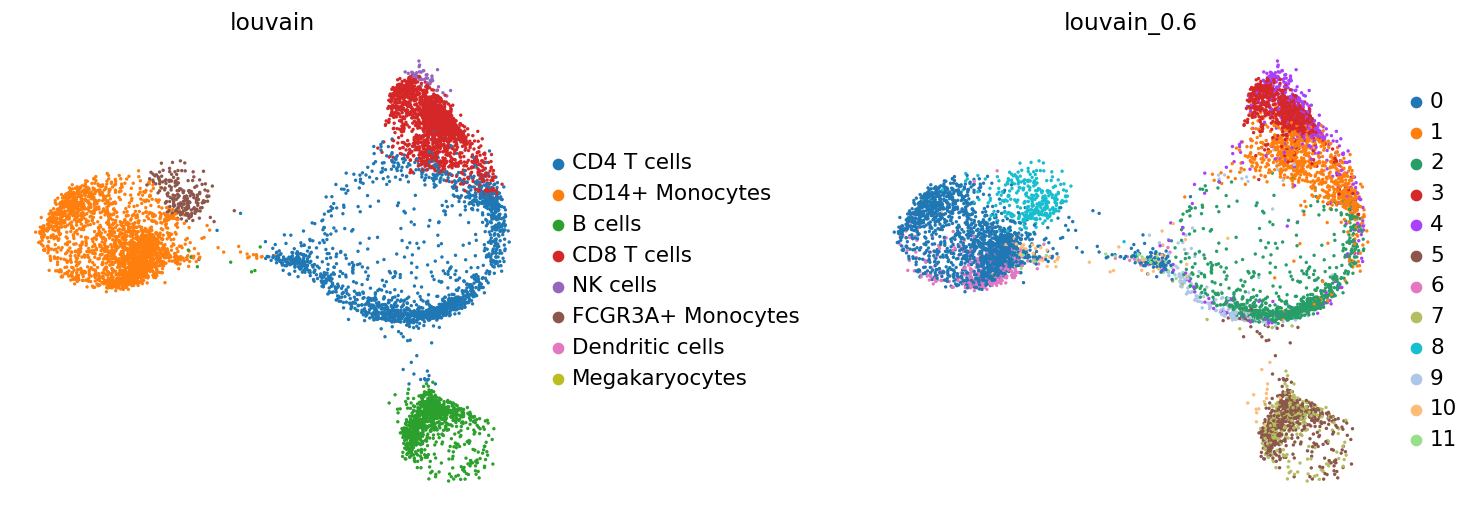

In [31]:
adata_ref_ = adata_ref[:, var_names]
adata_target_ = adata[:, var_names]

sc.pp.pca(adata_ref_)
sc.pp.neighbors(adata_ref_)
sc.tl.umap(adata_ref_)
sc.pp.pca(adata_target_)
sc.pp.neighbors(adata_target_)
sc.tl.umap(adata_target_)
sc.tl.ingest(adata_target_, adata_ref_, obs="louvain")

# to fix colors
adata_target_.uns["louvain_colors"] = adata_ref_.uns["louvain_colors"]
sc.pl.umap(adata_target_, color=["louvain", "louvain_0.6"], wspace=0.5)

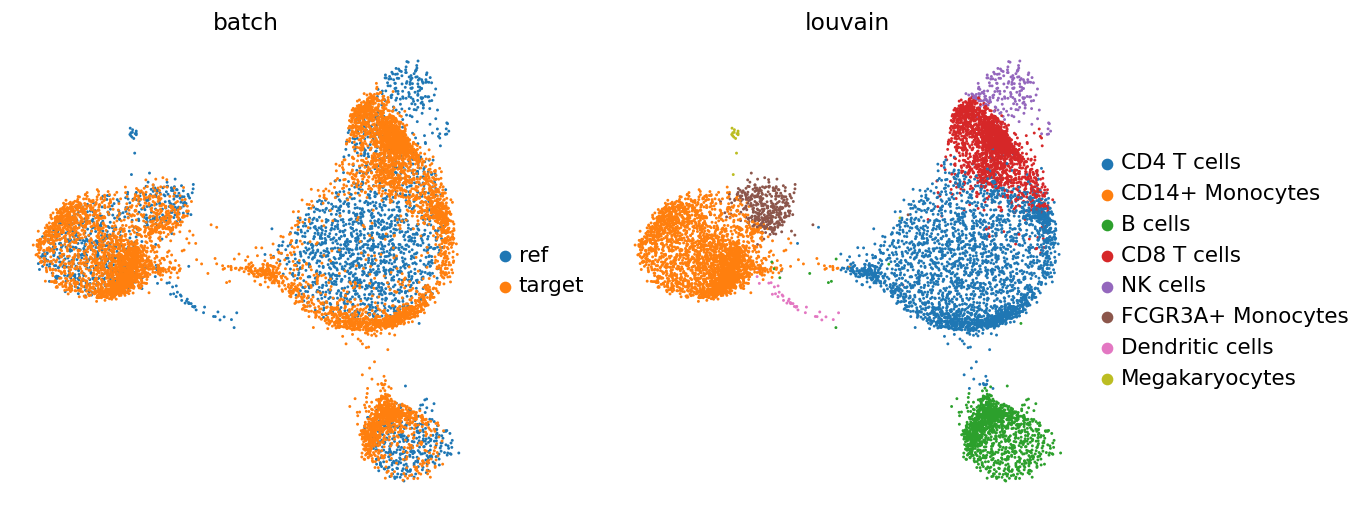

In [32]:
adata_concat = adata_ref_.concatenate(adata_target_, batch_categories=["ref", "target"])
adata_concat.obs.louvain = adata_concat.obs.louvain.astype("category")
# fix category ordering
adata_concat.obs.louvain.cat.reorder_categories(
    adata_ref.obs.louvain.cat.categories,
)
# fix category colors
adata_concat.uns["louvain_colors"] = adata_ref.uns["louvain_colors"]
sc.pl.umap(adata_concat, color=["batch", "louvain"])

임베딩에서 그룹의 Density plot 하위 집합을 부분적으로 시각화하기

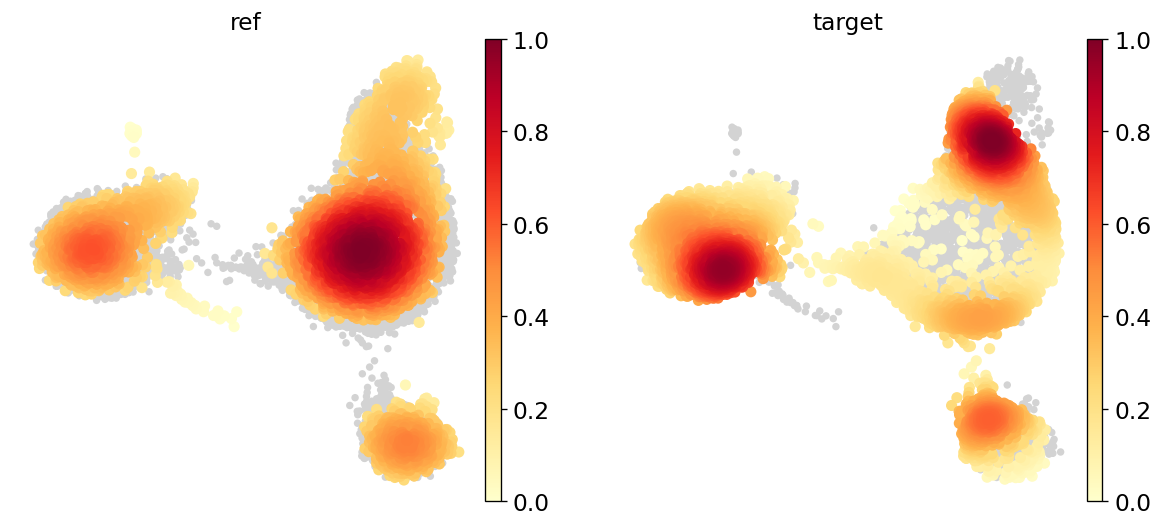

In [33]:
sc.tl.embedding_density(adata_concat, groupby="batch")
sc.pl.embedding_density(adata_concat, groupby="batch", ncols=2)

각각의 `leiden_0.6` 클러스터에 어떤 세포 유형들이 들어 있는지 막대 그래프를 그려봅니다.

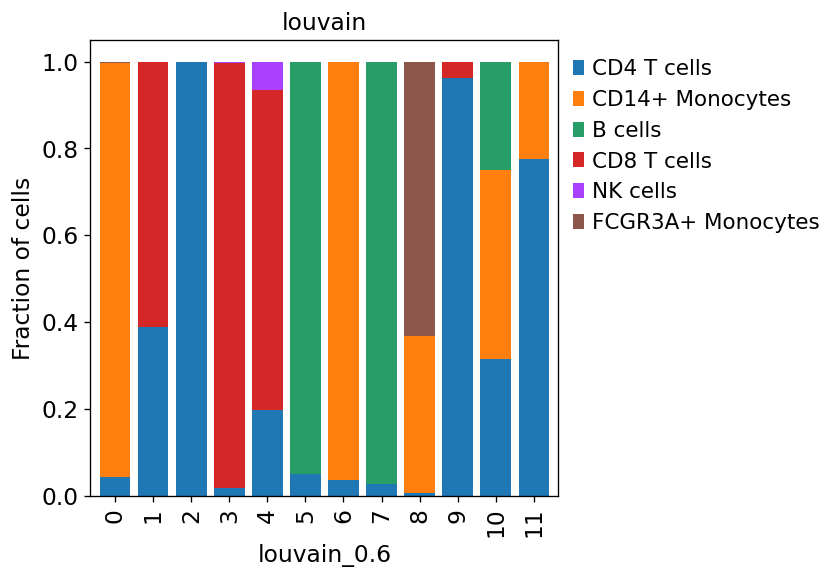

In [34]:
def plot_stacked_bar(data, index_col, columns_col, legend_position):
    tmp = pd.crosstab(data.obs[index_col], data.obs[columns_col], normalize="index")
    ax = tmp.plot.bar(stacked=True, grid=False, width=0.8)
    ax.legend(bbox_to_anchor=legend_position, loc="upper right", frameon=False)
    ax.set_xlabel(index_col)
    ax.set_ylabel("Fraction of cells")
    ax.set_title(columns_col)
    return ax

ax = plot_stacked_bar(adata_concat, "louvain_0.6", "louvain", (1.6, 1))
plt.show()

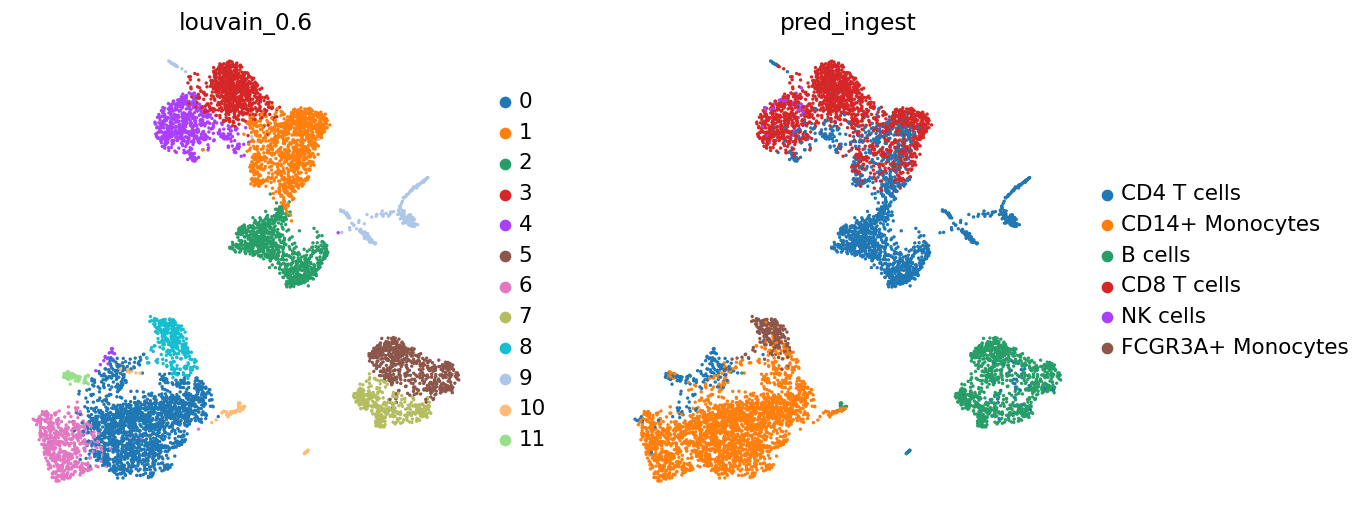

In [48]:
pred_ingest = adata_concat[adata_concat.obs["batch"] == "target"].obs['louvain']
# 인덱스에서 '-target' 제거
pred_ingest.index = pred_ingest.index.str.replace('-target', '', regex=False)

adata.obs["pred_ingest"] = pred_ingest

sc.pl.umap(adata, color=["louvain_0.6", "pred_ingest"], ncols=2)

위 시각화 결과를 보면 어떤 클러스터는 명확한 예측 결과를 보여지만 다른 클러스터에서는 여러 세포유형의 섞여있는 것으로 보입니다. 이런 경우에는 해당 클러스터에 속한 세포들이 어떤 유전자를 발현하는지 살펴보고 생물학적 지식을 활용해 결정해야 합니다.

## 마커 유전자를 사용해 예측하기

세포 유형을 예측하는데 가장 많이 사용되는 방법은 알려진 마커 유전자 목록과 비교해보는 방법입니다. 이 방법을 위해서는 신뢰할 수 있고 분석중인 샘플과 연관된 마커 유전자 목록이 필요합니다. 여기서는 사람 세포의 마커 유전자 목록을 불러와 사용하겠습니다.

In [13]:
# 사람 세포 마커 유전자 목록 불러오기
path_file = "./input/human_cell_markers.txt"
df = pd.read_table(path_file)
print(df.shape)

(2868, 15)


파일에는 2868개의 유전자가 포함되어 있네요. 세포 유형 예측을 위해 약간의 수정을 통해 `gene_dict` 객체를 만들어 줍니다.

In [14]:
# 세포 유형별 유전자 수에 대한 필터링
df["nG"] = df.geneSymbol.str.split(",").str.len()

df = df[df["nG"] > 5]
df = df[df["nG"] < 100]
df = df[df["cancerType"] == "Normal"]

df.index = df.cellName
gene_dict = df.geneSymbol.str.split(",").to_dict()

df.head()

,speciesType,tissueType,UberonOntologyID,cancerType,cellType,cellName,CellOntologyID,cellMarker,geneSymbol,geneID,proteinName,proteinID,markerResource,PMID,Company,nG
13,Human,Liver,UBERON_0002107,Normal,Normal cell,Kupffer cell,CL_0000091,"CD11b, CD14, CD18, CD32, CD68","ITGAM, CD14, ITGB2, [FCGR2A, FCGR2B, FCGR2C], ...","3684, 929, 3689, [2212, 2213, 9103], 968","ITAM, CD14, ITB2, [FCG2A, FCG2B, FCG2C], CD68","P11215, P08571, P05107, [P12318, P31994, P3199...",Experiment,17692868,NaN,7.0
22,Human,Peripheral blood,UBERON_0005408,Normal,Normal cell,Monocyte,CL_0000576,"CD11b, CD16, CD19, CD2, CD3, CD56, CD94, NKG2A","ITGAM, [FCGR3A, FCGR3B], CD19, CD2, [CD3D, CD3...","3684, [2214, 2215], 930, 914, [915, 916, 917],...","ITAM, [FCG3A, FCG3B], CD19, CD2, [CD3D, CD3E, ...","P11215, [P08637, O75015], P15391, P06729, [P04...",Experiment,29610856,NaN,11.0
23,Human,Blood,UBERON_0000178,Normal,Normal cell,Natural killer cell,CL_0000623,"CD11b, CD16, CD19, CD2, CD3, CD56, CD94, NKG2A","ITGAM, [FCGR3A, FCGR3B], CD19, CD2, [CD3D, CD3...","3684, [2214, 2215], 930, 914, [915, 916, 917],...","ITAM, [FCG3A, FCG3B], CD19, CD2, [CD3D, CD3E, ...","P11215, [P08637, O75015], P15391, P06729, [P04...",Experiment,29610856,NaN,11.0
25,Human,Gingiva,UBERON_0001828,Normal,Normal cell,Mesenchymal stem cell,CL_0000134,"CD105, CD166, CD29, CD44, CD49e, CD73, CD90","ENG, ALCAM, ITGB1, CD44, ITGA5, NT5E, THY1","2022, 214, 3688, 960, 3678, 4907, 7070","EGLN, CD166, ITB1, CD44, ITA5, 5NTD, THY1","P17813, Q13740, P05556, P16070, P08648, P21589...",Experiment,29604386,NaN,7.0
28,Human,Peripheral blood,UBERON_0005408,Normal,Normal cell,Monocyte,CL_0000576,"CD14, CD19, CD20, CD27, CD3, CD38, IgA, IgG","CD14, CD19, MS4A1, CD27, [CD3D, CD3E, CD3G], C...","929, 930, 931, 939, [915, 916, 917], 952, 973,...","CD14, CD19, CD20, CD27, [CD3D, CD3E, CD3G], CD...","P08571, P15391, P11836, P26842, [P04234, P0776...",Experiment,29579044,NaN,10.0


이제 `gseapy.enrichr` 함수를 사용해 위에서 만든 `gene_dict`과 `louvain_0.6`의 DEG 목록과 비교해 세포 유형을 예측합니다.

In [17]:
# 클러스터별로 DEG 분석
sc.tl.rank_genes_groups(
    adata, "louvain_0.6", method="wilcoxon", key_added="wilcoxon"
)

gsea_res = {}
pred = {}

for cl in adata.obs["louvain_0.6"].cat.categories.tolist():
    glist = (
        sc.get.rank_genes_groups_df(adata, group=cl, key="wilcoxon")["names"]
        .squeeze()
        .str.strip()
        .tolist()
    )
    enr_res = gseapy.enrichr(
        gene_list=glist[:300],
        organism="Human",
        gene_sets=gene_dict,
        background=adata.layers["counts"].shape[1],
        cutoff=1,
    )
    if enr_res.results.shape[0] == 0:
        pred[cl] = "Unass"
    else:
        enr_res.results.sort_values(by="P-value", axis=0, ascending=True, inplace=True)
        gsea_res[cl] = enr_res
        pred[cl] = enr_res.results["Term"][0]

pred

{'0': 'Circulating fetal cell',
 '1': 'CD4+ T cell',
 '2': 'CD4+ T cell',
 '3': 'CD8+ T cell',
 '4': 'CD1C+_A dendritic cell',
 '5': 'B cell',
 '6': 'CD16+ dendritic cell',
 '7': 'B cell',
 '8': 'Circulating fetal cell',
 '9': 'Circulating fetal cell',
 '10': 'Circulating fetal cell',
 '11': 'Circulating fetal cell'}

예측된 결과를 시각화로 살펴봅니다.

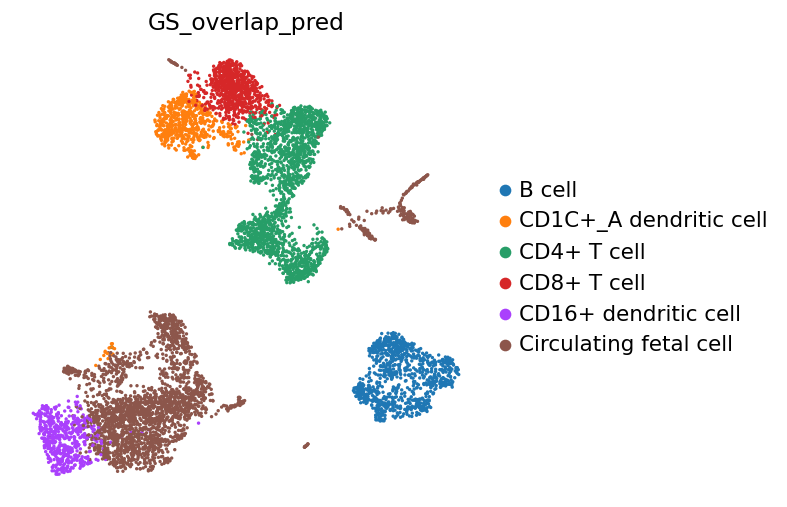

In [18]:
prediction = [pred[x] for x in adata.obs["louvain_0.6"]]
adata.obs["GS_overlap_pred"] = prediction

sc.pl.umap(adata, color="GS_overlap_pred")

## 세포유형 지정하기

위에서 얻은 결과를 통해 세포 유형을 지정하고 시각화 해봅니다.

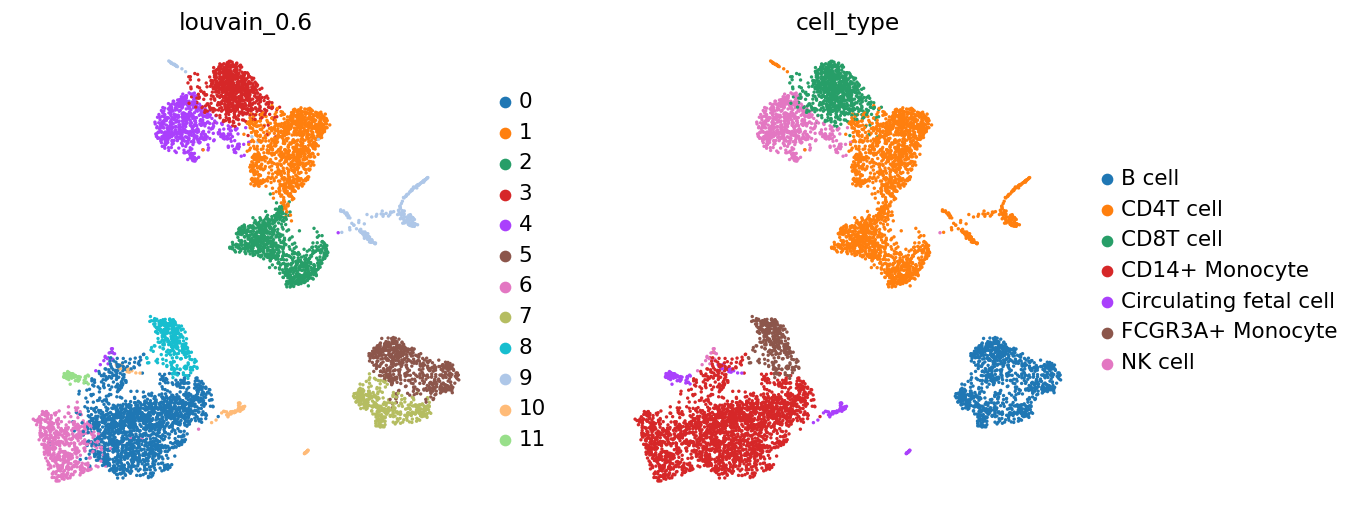

In [35]:
# 임의로 주석
cluster_annotations = {
    '0': 'CD14+ Monocyte',
    '1': 'CD4T cell',
    '2': 'CD4T cell',
    '3': 'CD8T cell',
    '4': 'NK cell',
    '5': 'B cell',
    '6': 'CD14+ Monocyte',
    '7': 'B cell',
    '8': 'FCGR3A+ Monocyte',
    '9': 'CD4T cell',
    '10': 'Circulating fetal cell',
    '11': 'Circulating fetal cell',
}

adata.obs['cell_type'] = adata.obs['louvain_0.6'].map(cluster_annotations)

# 주석 확인
sc.pl.umap(adata, color=["louvain_0.6", "cell_type"])

# 유전자 세트 분석(GSA)

유전자 세트 분석(Gene Set Analysis, GSA)은 생물학적 의미를 해석하기 위해 미리 정의된 유전자 집합을 사용하는 방법입니다. GSA는 일반적으로 다음과 같은 절차를 따릅니다:

1. **유전자 집합 정의**: 특정 생물학적 경로, 기능, 질병 등과 관련된 유전자 리스트를 만듭니다.
2. **데이터 준비**: 유전자 발현 데이터나 유전자 변이 데이터를 수집합니다.
3. **유전자 집합 평가**: 특정 조건에서 유전자 집합의 발현 수준이나 변이 정도를 평가합니다.
4. **통계 분석**: 유의미한 변화를 보이는 유전자 집합을 찾기 위해 통계적 방법을 사용합니다.

GSA의 주요 장점은 개별 유전자보다 유전자 집합 전체를 분석하여 생물학적 해석을 더 명확하게 할 수 있다는 점입니다. 이는 연구자가 특정 조건에서 어떤 경로나 기능이 활성화되었는지 이해하는 데 도움을 줍니다.

## Over-representation analysis (ORA)

ORA는 주어진 유전자 목록에서 특정 기능이나 경로에 속하는 유전자들이 과발현 되는지를 평가하는 방법입니다. ORA는 특정 생물학적 기능이나 경로와 관련된 유전자들이 관심 있는 유전자 목록에서 통계적으로 유의미하게 많이 포함되어 있는지 확인합니다. 이를 통해 특정 생물학적 기능이나 경로가 실험 조건에서 중요한 역할을 하는지 파악할 수 있습니다. ORA을 하면 유의미성을 나타내는 `p-value`와 함께 과도하게 나타나는 유전자 집합 결과를 얻습니다. 다만 유전자 발현 수준이나 경로의 구조를 고려하지 않는다는 한계점이 있습니다.

이제 예시로 코로나 환자의 DEG를 사용하여 면역 반응, 염증 경로, 바이러스 복제와 관련된 경로들이 유의미하게 변화하는지를 살펴보겠습니다.

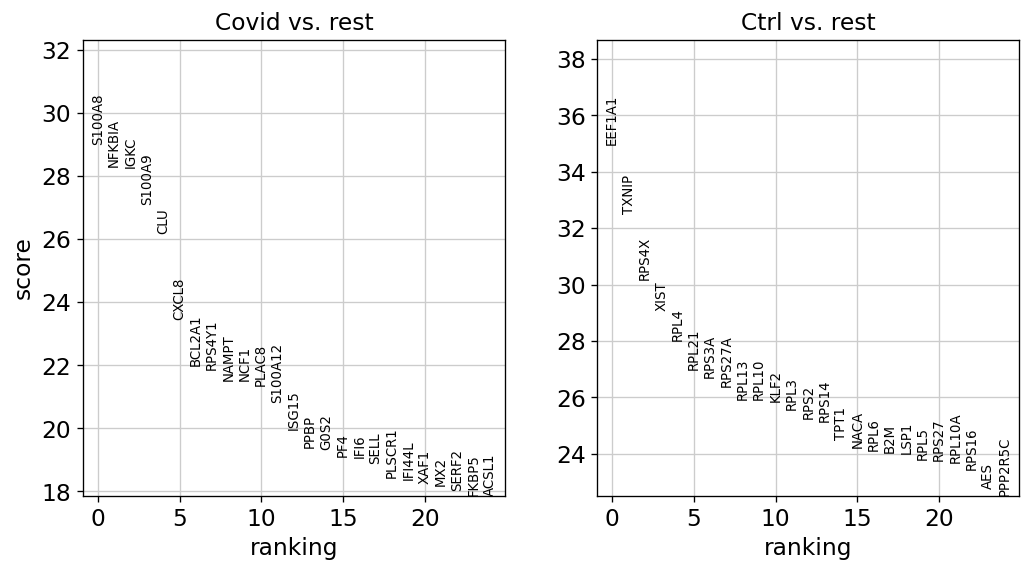

In [22]:
sc.tl.rank_genes_groups(adata, "type", method="wilcoxon", key_added="wilcoxon")
sc.pl.rank_genes_groups(
    adata,
    n_genes=25,
    sharey=False,
    key="wilcoxon",
    ncols=3,
)

앞서 구한 DEG 목록을 `gseapy`에 넘겨서 ORA 분석을 진행합니다. 많이 사용되는 몇가지 데이터베이스 목록은 아래와 같습니다.

- GO_Biological_Process_2018
- KEGG_2019_Human
- KEGG_2019_Mouse
- WikiPathways_2019_Human
- WikiPathways_2019_Mouse


In [23]:
# 가능한 데이터베이스 : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’
gene_set_names = gseapy.get_library_name(organism="Human")

# ?gseapy.enrichr
glist = (
    sc.get.rank_genes_groups_df(
        adata, group="Covid", key="wilcoxon", log2fc_min=0.25, pval_cutoff=0.05
    )["names"]
    .squeeze()
    .str.strip()
    .tolist()
)

간단한 막대그래프를 사용해 결과를 시각화합니다.

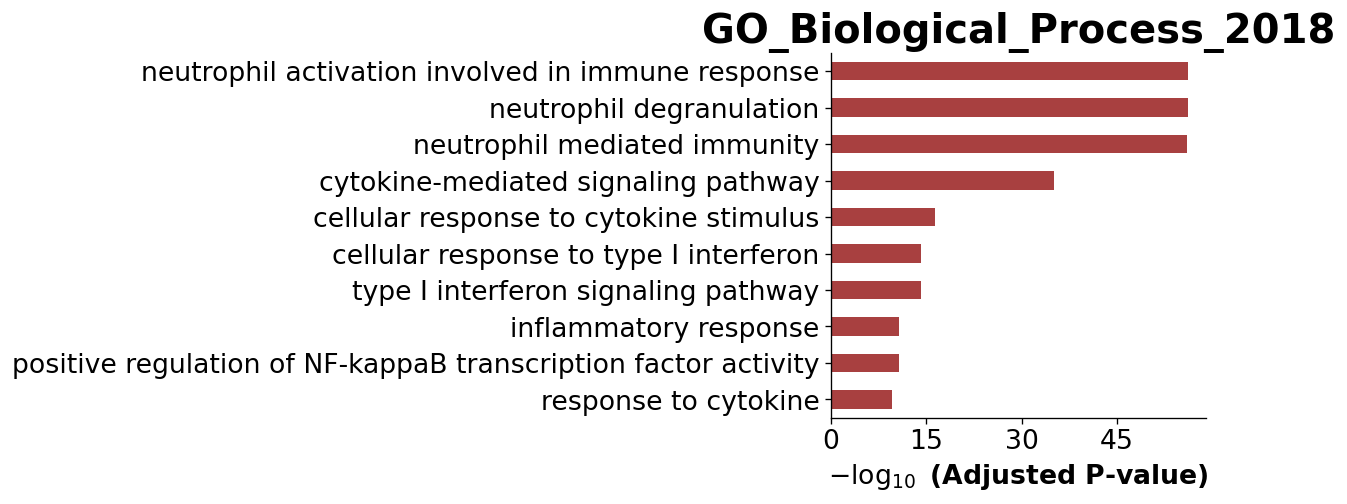

In [49]:
def plot_ora(glist, gene_set="GO_Biological_Process_2018", size=(4, 4), color="darkred", truncate=True):
    enr_res = gseapy.enrichr(
        gene_list=glist,
        organism="Human",
        gene_sets=gene_set,
        cutoff=0.5,
    )
    if truncate:
        # True 시 뒤의 코드명 일부 제거.
        enr_res.res2d["Term"] = enr_res.res2d["Term"].apply(
            lambda x: " ".join(x.split(" ")[:-1])
        )
    ax = gseapy.barplot(
        enr_res.res2d, title=gene_set,
        figsize=size,  color=color,)
    ax.grid(False)
    return ax

ax = plot_ora(glist, gene_set="GO_Biological_Process_2018", size=(4, 4), color="darkred", truncate=True)
plt.show()

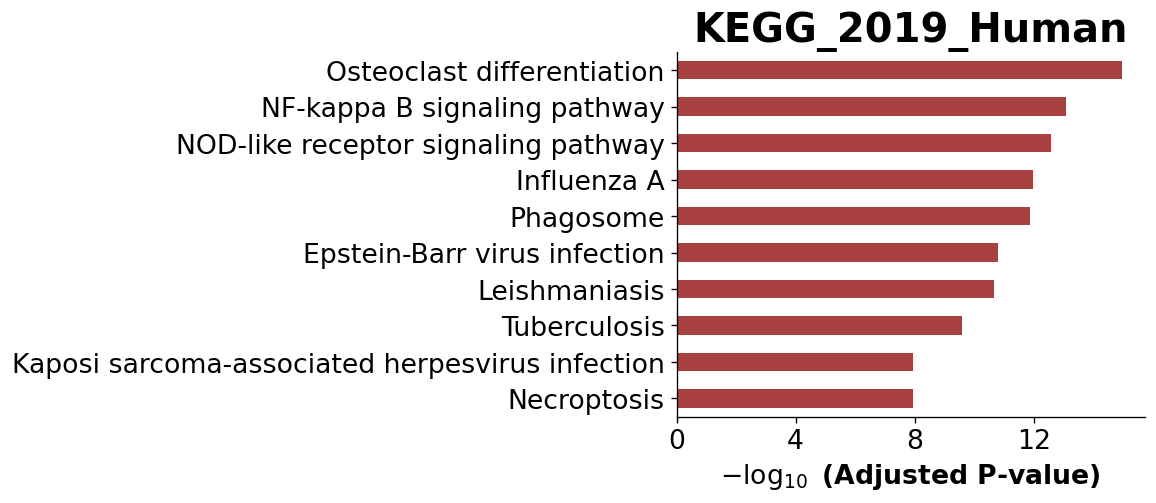

In [25]:
ax = plot_ora(glist, gene_set="KEGG_2019_Human", size=(5, 4), color="darkred", truncate=False)
plt.show()

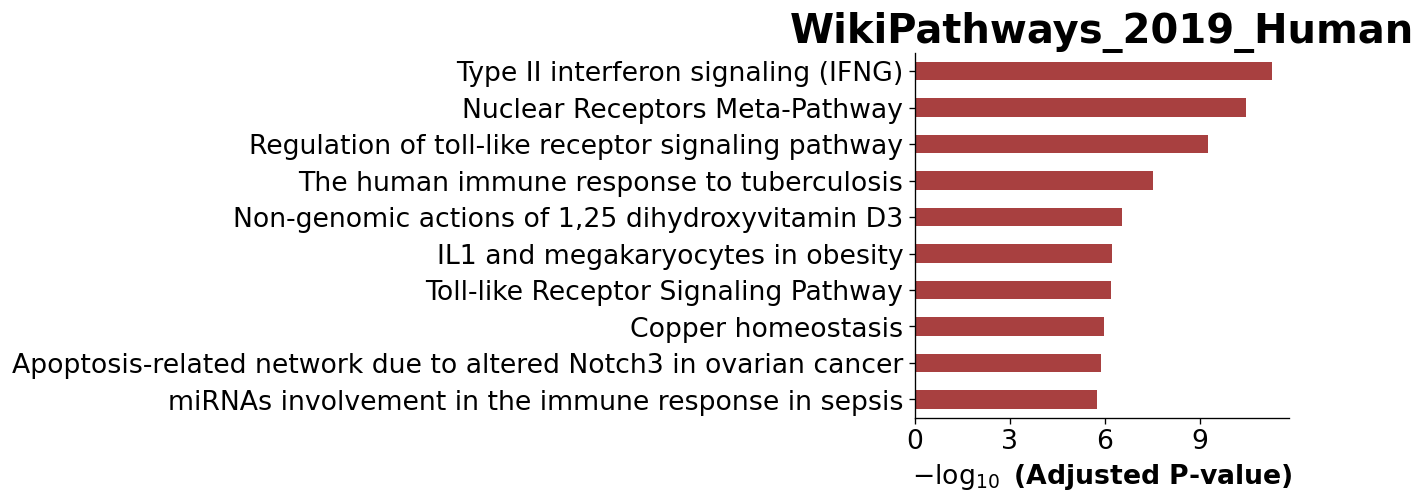

In [26]:
ax = plot_ora(glist, gene_set="WikiPathways_2019_Human", size=(4, 4), color="darkred", truncate=True)
plt.show()

## Functional Class Scoring (FCS) 분석

ORA외에도 Functional Class Scoring(FCS) 분석을 진행 할 수 있습니다. FCS는 유전자 집합 내 발현 변화 또한 고려한 방법입니다. FCS 분석 중 유명한 방법이 유전자 세트 강화 분석(GSEA)입니다. GSEA는 각 유전자에 발현 변화(예: 로그 폴드 변화)를 기준으로 점수를 부여하고, 이 점수를 유전자 집합 내에서 합산하거나 평균을 구한 후, 무작위 분포(퍼뮤테이션 기반 또는 파라메트릭)와 비교합니다. 그 결과 (일반적으로 폴드 변화를 기반으로) 순위가 매겨진 유전자 목록을 점수화하고 순열 테스트를 계산하여 특정 유전자 세트가 상향 조절된 유전자에 더 많이 존재하는지, 하향 조절된 유전자에 더 많이 존재하는지, 아니면 차등 조절되지 않는지를 확인할 수 있습니다. 이 방법의 장점은 발현 수준을 고려하기 때문에 미묘한 효과도 포착할 수 있다는 것입니다. 다만 집합내 유전자들이 서로 독립이라는 가정해야 한다는 한계점이 있습니다.

GSEA를 수행하기 위해서는 모든 차등 발현 유전자(DEG)와 그 로그 폴드 체인지를 포함한 테이블이 필요합니다.

In [27]:
# Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’
gene_set_names = gseapy.get_library_name(organism="Human")

gene_rank = sc.get.rank_genes_groups_df(adata, group="Covid", key="wilcoxon")[
    ["names", "logfoldchanges"]
]
gene_rank.sort_values(by=["logfoldchanges"], inplace=True, ascending=False)

# 계산_qc_metrics는 유전자당 세포 수를 계산합니다.
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# 최소 30개 이상의 세포에서 발현되는 유전자를 필터링합니다.
gene_rank = gene_rank[
    gene_rank["names"].isin(adata.var_names[adata.var.n_cells_by_counts > 30])
]

gene_rank

,names,logfoldchanges
2800,CCL7,24.208344
2868,IL1A,24.117874
2360,CYP19A1,23.754789
2903,PRTN3,23.376261
1107,NXF3,9.236358
...,...,...
16567,ENHO,-4.197762
15497,LYNX1,-4.719684
15466,C5orf17,-5.105195
17113,LYPD2,-5.713926


다음으로 GSEA를 실행합니다. 그러면 여러 경로에 대한 정보가 포함된 테이블이 생성됩니다. 이 테이블을 `p-value` 또는 정규화된 강화 점수(NES) 기준으로 정렬하고 필터링하여 상위 경로만 시각화할 수 있습니다. 이 분석은 실험 조건에서 중요한 역할을 하는 주요 경로를 식별하고 분석할 수 있습니다.

In [28]:
res = gseapy.prerank(rnk=gene_rank, gene_sets="KEGG_2021_Human")

terms = res.res2d.Term
print(terms[:10])

0                              IL-17 signaling pathway
1                                 Rheumatoid arthritis
2    Viral protein interaction with cytokine and cy...
3               Cytokine-cytokine receptor interaction
4    AGE-RAGE signaling pathway in diabetic complic...
5                          Chemokine signaling pathway
6                                           Amoebiasis
7               Fluid shear stress and atherosclerosis
8                           Osteoclast differentiation
9                                            Pertussis
Name: Term, dtype: object


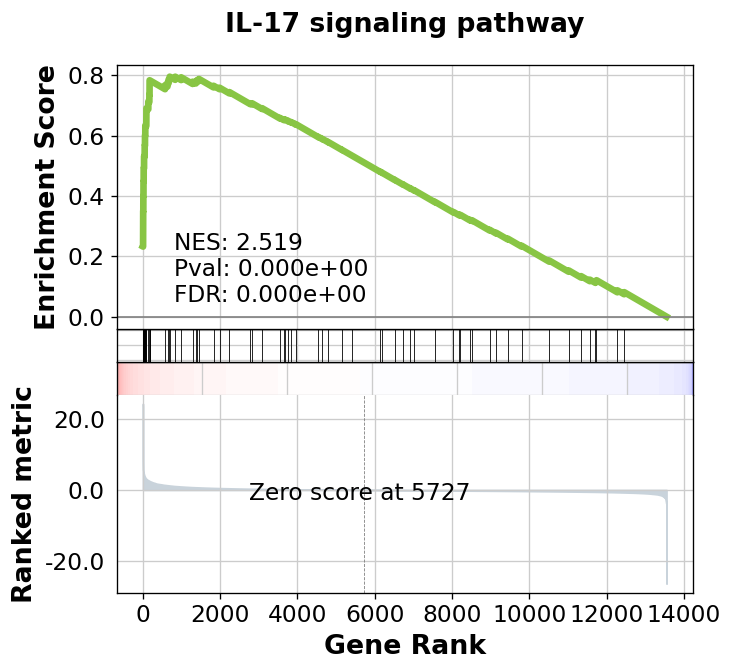

In [29]:
gseapy.gseaplot(rank_metric=res.ranking, term=terms[0], **res.results[terms[0]])
plt.show()

위 결과를 보면 KEGG 데이터베이스의 `IL-17 signaling pathway` 경로가 과발현 되어 있다는 것을 알 수있습니다. `IL-17`은 염증 반응을 조절하는 중요한 사이토카인입니다. 이 경로의 상향 조절은 강한 염증 반응을 나타내며, 면역계가 병원체와 싸우는 과정에서 중요한 역할을 합니다. 따라서 이런 경로의 상향 조절은 염증, 면역 반응, 감염 및 대사질환과 관련된 중요한 생물학적 변화를 시사합니다.

마지막으로, 다른 분석을 위해 데이터를 저장해 보겠습니다.

In [30]:
save_file = "./output/covid/results/scanpy_covid_annot.h5ad"
adata.write_h5ad(save_file, compression="gzip")

# 나가며

지금까지 세포 유형 예측을 통해 클러스터의 세포 주석을 추가하고 유전자 세트 분석(GSA)을 수행하는 간단한 방법을 살펴보았습니다. 이를 통해 데이터의 생물학적 의미를 보다 명확하게 이해할 수 있었습니다. 다음으로 이러한 분석보다 심화된 예제로 학습을 계속하겠습니다.